# 1. Activation function

In [1]:
import torch, numpy

In [4]:
def sigma(x):
    return torch.tanh(x)
    
def dsigma(x):
    return (1-torch.tanh(x)**2).mean()

# 2. Loss

In [5]:
def loss(x,y):
    return torch.norm(x-y)**2

def dloss(x,y):
    return 2*(x-y)

# 3. Forward and backward passes

In [6]:
def forward(w1, b1, w2, b2, x):
    s1=torch.mm(w1, x)+b1
    x1=sigma(s1)
    s2=torch.mm(w2, x1)+b2
    x2=sigma(s2)
    return x, s1, x1, s2, x2
    
def backward_pass(w1, b1, w2, b2, t, x, s1, x1, s2, x2, dl_dw1, dl_db1, dl_dw2, dl_db2):
    dl_dx2=dloss(x2, t)
    dl_dx1=torch.mm(w2.T, dloss(x2, t)) * dsigma(s2)
    dx1_dw1=dsigma(s1) * x.T
    dx2_ds2=dsigma(s2)
    dl_ds2=dx2_ds2*dl_dx2
    dl_ds1=dl_dx1*dsigma(s1)
    #gradients
    dl__dw1=torch.mm(dl_dx1,dx1_dw1)
    dl__dw2=torch.mm(dl_ds2, x1.T)
    dl__db1=dl_ds1
    dl__db2=dl_ds2
    
    return dl__dw1, dl__dw2, dl__db1, dl__db2
    
    

In [5]:
# x, s1, x1, s2, x2 = forward(w1, b1, w2, b2, train_input[0].unsqueeze(1))
# t=torch.randn(x2.size())

In [6]:
# backward_pass(w1, b1, w2, b2, t, x, s1, x1, s2, x2, dl_dw1, dl_db1, dl_dw2, dl_db2);

# 4. Data

In [8]:
from  dlc_practical_prologue import load_data
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [9]:
train_target=train_target*0.9
test_target=test_target*0.9

In [10]:
import matplotlib.pyplot as plt, numpy

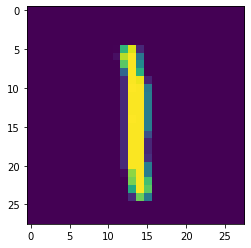

In [11]:
plt.imshow(train_input.unsqueeze(1)[14].view(28,28))

# Training the net

In [12]:
def prediction(x):
    idx=x.argmax(dim=1)
    pred=torch.zeros_like(x)
    pred[torch.arange(x.size(0)), idx]=0.9
    return pred

In [13]:
eps=1e-6
w1=torch.normal(mean=torch.zeros((50, 784)), std=torch.ones((50, 784))*eps)
w2=torch.normal(mean=torch.zeros((10, 50)), std=torch.ones((10, 50))*eps)
b1=torch.normal(mean=torch.zeros((50, 1)), std=torch.ones((50, 1))*eps)
b2=torch.normal(mean=torch.zeros((10, 1)), std=torch.ones((10, 1))*eps)

dl_dw1=torch.zeros_like(w1)
dl_dw2=torch.zeros_like(w2)
dl_db1=torch.zeros_like(b1)
dl_db2=torch.zeros_like(b2)

num_epoch=400
lr=1e-4

for i in range(num_epoch):
    sum_dl_dw1=torch.zeros_like(dl_dw1)
    sum_dl_dw2=torch.zeros_like(dl_dw2)
    sum_dl_db1=torch.zeros_like(dl_db1)
    sum_dl_db2=torch.zeros_like(dl_db2)
    X2=[]
    X2_t1=[]
    for idx in range(train_input.size(0)):
        x=train_input[idx].unsqueeze(1)
        t=train_target[idx].unsqueeze(1)
        t1=test_target[idx].unsqueeze(1)
        x_t1=test_input[idx].unsqueeze(1)
        _, s1, x1, s2, x2 = forward(w1, b1, w2, b2, x)
        X2.append(x2.T)
        _, _, _, _, x2_t1=forward(w1, b1, w2, b2, x_t1)
        dl_dw1, dl_dw2, dl_db1, dl_db2 = backward_pass(w1, b1, w2, b2, t, x, s1, x1, s2, x2, dl_dw1, dl_db1, dl_dw2, dl_db2)
        X2_t1.append(x2_t1)
        sum_dl_dw1 += dl_dw1
        sum_dl_dw2 += dl_dw2
        sum_dl_db1 += dl_db1
        sum_dl_db2 += dl_db2
        
    X2 = torch.stack(X2, dim=0).squeeze()
    X2_t1 = torch.stack(X2_t1, dim=0).squeeze()
    
    w1 -= lr*sum_dl_dw1
    w2 -= lr*sum_dl_dw2
    b1 -= lr*sum_dl_db1
    b2 -= lr*sum_dl_db2
    
    accuracy2 = ((prediction(X2_t1) == test_target).all(dim=1)*1.0).mean()
#     if accuracy2>0.78:
#         lr=lr/1.1 #this will reduce the learning rate when good accuracy is achieved in order to avoid overfitting and divergence
        
    if i%10 == 0:
        accuracy1 = ((prediction(X2) == train_target).all(dim=1)*1.0).mean()
        accuracy2 = ((prediction(X2_t1) == test_target).all(dim=1)*1.0).mean()
        print("Epoch : {}/{}, training loss : {:.3f}, test loss : {:.3f}, accu_train : {:.2f}%, accu_test : {:.2f}%".format(i, num_epoch, \
                                                           loss(x2, t), loss(x2_t1, t1), accuracy1*100, accuracy2*100))

Epoch : 0/400, training loss : 0.810, test loss : 0.810, accu_train : 9.70%, accu_test : 8.50%
Epoch : 10/400, training loss : 0.739, test loss : 0.731, accu_train : 11.70%, accu_test : 9.90%
Epoch : 20/400, training loss : 0.739, test loss : 0.730, accu_train : 11.70%, accu_test : 9.90%
Epoch : 30/400, training loss : 0.739, test loss : 0.728, accu_train : 26.10%, accu_test : 21.80%
Epoch : 40/400, training loss : 0.742, test loss : 0.627, accu_train : 32.20%, accu_test : 29.50%
Epoch : 50/400, training loss : 0.496, test loss : 0.603, accu_train : 53.10%, accu_test : 47.60%
Epoch : 60/400, training loss : 0.453, test loss : 0.601, accu_train : 59.40%, accu_test : 55.90%
Epoch : 70/400, training loss : 0.369, test loss : 0.668, accu_train : 72.00%, accu_test : 66.30%
Epoch : 80/400, training loss : 0.288, test loss : 0.776, accu_train : 77.00%, accu_test : 70.60%
Epoch : 90/400, training loss : 0.251, test loss : 0.719, accu_train : 81.80%, accu_test : 73.00%
Epoch : 100/400, training

In [14]:
prediction(X2).argmax(dim=1)

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 7, 4, 0, 9, 1,
        5, 2, 4, 3, 2, 7, 3, 8, 6, 7, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        5, 3, 3, 0, 7, 4, 9, 7, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 7, 0, 2, 6, 7, 8, 3, 7, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1, 9, 7, 1, 7, 1, 1, 6, 3, 0, 6, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0,
        2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4, 5, 7, 5, 3, 3, 1, 5, 4, 7, 7, 4, 2,
        8, 5, 8, 6, 7, 3, 4, 6, 1, 9, 7, 6, 0, 3, 7, 2, 7, 2, 9, 4, 4, 6, 4, 9,
        7, 0, 9, 2, 7, 5, 1, 5, 9, 1, 2, 3, 7, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5,
        0, 7, 4, 9, 7, 8, 3, 2, 1, 1, 5, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3,
        0, 4, 6, 5, 2, 6, 4, 7, 7, 8, 9, 9, 5, 0, 7, 1, 6, 2, 0, 3, 5, 4, 6, 5,
        1, 6, 3, 7, 5, 8, 0, 9, 1, 0, 7, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 0, 7,
        9, 8, 5, 9, 7, 1, 1, 4, 4, 5, 6, 4, 1, 2, 6, 3, 9, 3, 9, 0, 5, 9, 6, 5,
        7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3,

In [15]:
((train_target.argmax(dim=1)==prediction(X2).argmax(dim=1))*1.0).mean()

tensor(0.9240)

In [16]:
((test_target.argmax(dim=1)==prediction(X2_t1).argmax(dim=1))*1.0).mean()

tensor(0.7490)